# Exercise 04: Bayesian Inverse Problems

In this notebook, we (finally!) get started with uncertainty quantification for inverse problems by way of Bayesian inference.

In essence, the goal of inverse problems is to infer the parameters of a physical model from observations. In the context of uncertainty quantification, we are interested in the uncertainty of the inferred parameters.

In the Bayesian framework, uncertainty is quantified by a probability distribution over the parameter space. Finally, in Bayesian inference we use Bayes' theorem to define the *posterior distribution* of the parameters by combining prior knowledge and observed data.

The aim of this notebook is to show how to use CUQIpy to combine the all the components needed for Bayesian inference in a way that closely matches the mathematical formalism.

**Try to run through parts 1 and 2 before working on the optional exercises**

## Learning objectives
Going through the notebook, you will see how to:

* Define distributions for each of the relevant parameters of an inverse problem from the CUQIpy library.
* Define a "Bayesian model" by combining distributions into a joint distribution.
* Construct a posterior distribution by conditioning the joint distribution on observed data.
* Sample a posterior distribution with specific choice of sampler.
* Analyze the samples from the posterior distribution.
* Compute point estimates of posterior, e.g., MAP or ML.
* Describe how the high-level "BayesianProblem" combines the above steps into a convenient non-expert interface.


## Table of contents
1. [Defining the posterior distribution](#posterior)
2. [Sampling the posterior](#sampling)
3. [High level interface (BayesianProblem)](#BayesianProblem)
4. [Computing point estimates of the posterior](#pointestimates) ★


## References
[1] Gelman, Andrew, et al. "Bayesian workflow." arXiv preprint arXiv:2011.01808 (2020).


## Load modules
As we have seen a few times now, we start of by importing the Python packages we need (including CUQIpy).

In [35]:
import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.distribution import JointDistribution, GaussianCov, Cauchy_diff, Laplace_diff, GMRF, Laplace, Lognormal, Gamma
from cuqi.problem import BayesianProblem
from cuqi.testproblem import Deconvolution1D, Deconvolution2D

# 1. Defining the posterior distribution <a class="anchor" id="posterior"></a>

Solving a Bayesian inverse problem amounts to characterizing the posterior distribution. The posterior describes the probability distribution of the parameters we are interested in by combining our prior knowledge of the parameters with the data we have observed. In its most general form, the posterior is given by Bayes' theorem:

\begin{align*}
p(\theta \mid y) = \frac{p(y \mid \theta)p(\theta)}{p(y)} \propto p(y \mid \theta)p(\theta),
\end{align*}

where $\theta$ is the parameter vector of all the parameters we are interested in inferring and $y$ is the observable data. Here probability density function $p(\theta)$ is the prior distribution of the parameters and $p(y \mid \theta)$ is known as the likelihood function. The denominator $p(y)$ is the *evidence* and is a normalization constant (that we typically ignore because it does not affect the MCMC sampling) that ensures that the posterior integrates to 1.


### Note on Bayesian modelling with CUQIpy

CUQIpy uses a general approach to Bayesian modeling that not only aims to define the posterior distribution, but also to define the joint distribution of all the parameters. This more general approach is useful because it allows one to carry out more tasks related to the Bayesian workflow such as prior predictive checks, model checking and posterior predictive checks. For more details, see [1].

In this notebook, we will only focus on defining the posterior distribution for an inverse problem using this general approach. In short, the posterior is defined by *conditioning* the joint distribution of all the random variables on the observed data using Bayes' theorem and can be summarized in the following steps:

1. Define the deterministic forward model.
2. Define distributions for each of the random variables.
4. Combine the distributions into a joint distribution.
5. Condition the joint distribution on the observed data to obtain the posterior distribution.

We now go through these steps in more detail.

## 1.1 Deterministic forward model and data
Consider an inverse problem
$$
\mathbf{y}=\mathbf{A}(\mathbf{x}) + \mathbf{e},
$$

where $\mathbf{A}: \mathbb{R}^n \to \mathbb{R}^m$ is the forward model of the inverse problem, $\mathbf{y}^\mathrm{data}\in\mathbb{R}^m$ is the data and $\mathbf{x}^\mathrm{exact}\in \mathbb{R}^n$ is the parameter of interest.

For this example let us revisit the `Deconvolution1D` testproblem and extract a CUQIpy forward model and some synthetic data (in this case generated from the `sinc` phantom). Note that his is a linear inverse problem, but the same approach can be used for nonlinear inverse problems as well.

In [7]:
# Load forward model, data and problem information
A, y_data, probInfo = Deconvolution1D.get_components(phantom="sinc")

# For convenience, we define the dimension of the domain
n = A.domain_dim

Before going further let us briefly visualize the data and compare with the exact solution to the problem. Here we should expect to see that the data is a convolved version of the exact solution with some added noise. We can also inspect the `probInfo` variable to get further information about the problem.

ProblemInfo with the following set attributes:
['infoString', 'exactSolution', 'exactData']
 infoString: Noise type: Additive Gaussian with std: 0.05


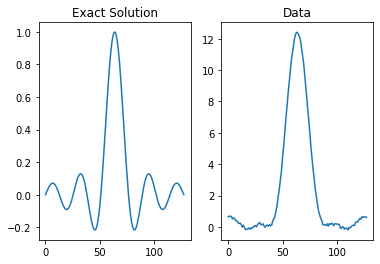

In [8]:
# Plot the data
plt.subplot(121); probInfo.exactSolution.plot(); plt.title('Exact Solution')
plt.subplot(122); y_data.plot(); plt.title('Data')

# Print information about the problem
print(probInfo)

## 1.2 Define distributions for each of the random variables

In the Bayesian setting we consider the unknown and observed parameters as random variables. The Bayesian model can be defined as

\begin{align*}
\mathbf{y} = \mathbf{A} \mathbf{x},
\end{align*}

where $\mathbf{y}$ and $\mathbf{x}$ are random variables. The goal now is to define distributions for each of these random variables. The way to think about this is that we are trying to define the a Bayesian model for the *data generating process* [1]. Here we are interested in the distribution of $\mathbf{x}$, but we also need to define the distribution of $\mathbf{y} \mid \mathbf{x}$.


For the unknown $\mathbf{x}$ we must use a priori knowledge to define a distribution. In this case the sinc phantom in the Deconvolution testproblem looks like it can be represented fairly well by a multivariate Gaussian distribution. Therefore we start by defining an i.i.d. Gaussian distribution for $\mathbf{x}$:

\begin{align*}
\mathbf{x} &\sim \mathcal{N}(\mathbf{0}, \sigma_\mathbf{x}^2 \mathbf{I}),
\end{align*}

with some choice of the standard deviation say $\sigma_\mathbf{x}=0.1$. This is done in CUQIpy as follows:

In [36]:
# Define prior standard deviation
σ_x = 0.1

# Define prior
x = GaussianCov(np.zeros(n), σ_x**2)

As mentioned, for random variable $\mathbf{y}$ representing the observed data, we are interested in defining the distribution of $\mathbf{y} \mid \mathbf{x}$.

Here we can use information about the known characteristics of the observed data in the problem. In this case according to the problem info string shown earlier, the noise is additive Gaussian with a standard deviation of 0.05 and because the noise is the only stochastic element of $\mathbf{y}$ when $\mathbf{x}$ is fixed we have

\begin{align*}
\mathbf{y} \mid \mathbf{x} &\sim \mathcal{N}(\mathbf{A}\mathbf{x}, \sigma_\mathbf{y}^2 \mathbf{I}),
\end{align*}

where $\sigma_\mathbf{y} = 0.05$. Notice that this definition depends both on the forward model $\mathbf{A}$ and the random variable $\mathbf{x}$.

In CUQIpy, we can define the distribution matching the mathematical expression using our variables `A` and `x` as follows:

In [11]:
# Define noise standard deviation
σ_y = 0.05

# Define distributions
y = GaussianCov(A@x, σ_y**2)

#### ★ Try yourself (optional):  

Have a look at the distributions for $\mathbf{x}$ and $\mathbf{y}$ by calling `print` on them. 
- How are the distributions of the two random variables different?
- Is it clear that the distribution for $\mathbf{y}$ is a conditional distribution?

In [14]:
# Your code here




### Note on notation

It is common (for convenience in terms of notation) not to explicitly write the dependance of each random variable when specifying a complete Bayesian model. For example, for the case above one would often write
\begin{align*}
\mathbf{x} &\sim \mathcal{N}(\mathbf{0}, \sigma_\mathbf{x}^2 I)\\
\mathbf{y} &\sim \mathcal{N}(\mathbf{A}\mathbf{x}, \sigma_\mathbf{y}^2 I),
\end{align*}

where the dependance of $\mathbf{y}$ on $\mathbf{x}$ is implicit.

## 1.3 Joint distribution

Up until now we have worked with $\mathbf{x}$ and $\mathbf{y}$ as two separate objects. However, in the Bayesian framework we are interested in the joint distribution over $\mathbf{x}$ and $\mathbf{y}$. The joint distribution is defined as the product of the individual probability density functions. In our simple case, the joint distribution can be described in density form as

$$
p(\mathbf{y},\mathbf{x}) = p(\mathbf{y} \mid \mathbf{x})p(\mathbf{x}).
$$

In CUQIpy, we can define the joint distribution simply by passing each of the distributions as arguments to the `JointDistribution` class.

In [17]:
# Define joint distribution p(y,x)
joint = JointDistribution(y, x)

Calling `print` on the joint distribution gives a nice overview matching the mathematical description above.

In [18]:
print(joint)

JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI GaussianCov. Conditioning variables ['x'].
	x ~ CUQI GaussianCov.
)


For the purpose of this notebook we are not going to dive further into the details of the joint distribution, and simply use it to define the posterior.

## 1.4 Conditioning on observed data to obtain the posterior

The final step in defining the posterior distribution is to condition the joint distribution $p(\mathbf{y},\mathbf{x})$ on the observed data. This is done by using Bayes' theorem, which in our simple case can easily be derived as

\begin{align*}
p(\mathbf{x} \mid \mathbf{y}) \propto L(\mathbf{x} \mid \mathbf{y})p(\mathbf{x}),
\end{align*}

where we use the notation $L(\mathbf{x} \mid \mathbf{y}) := p(\mathbf{y} \mid \mathbf{x})$ for the likelihood function to emphasize that it is a function on $\mathbf{x}$ and not on $\mathbf{y}$.

For the specific case of having observed $\mathbf{y}=\mathbf{y}^\mathrm{data}$, we write posterior distribution as $p(\mathbf{x} \mid \mathbf{y}^\mathrm{data})$.

CUQIpy can automatically derive the posterior distribution for any joint distribution by passing the observed data as an argument to the "call" method of the joint distribution. This is done as follows:

In [34]:
posterior = joint(y=y_data) # Applies Bayes' rule automatically

We can now inspect the posterior distribution by calling `print` on it. Notice that the posterior equation matches the mathematical expression above.

In [21]:
print(posterior)

Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI GaussianCov Likelihood function. Parameters ['x'].
 	x ~ CUQI GaussianCov.
 )


#### ★ Try yourself (optional):  
The posterior is essentially just another CUQIpy distribution. Have a look at the [Posterior class](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.Posterior.html) in the online documentation to see what attributes and methods are available.

What happens if you call the `sample` method?

In [33]:
# Your code here



# 2. Sampling the posterior <a class="anchor" id="sampling"></a>
In CUQIpy, we provide a number of samplers in the sampler module. All samplers have the same signature, namely
`Sampler(target, ...)`, where `target` is the target CUQIpy distribution and `...` indicates any (optional) arguments.

In the case of the posterior above which is defined from a linear model and Gaussian likelihood and prior, the Linear Randomize-then-Optimize [(Linear_RTO)](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.Linear_RTO.html#cuqi.sampler.Linear_RTO) sampler is a good choice. Like any of the other samplers, we set-up the sampler by simply providing the target distribution.

In [ ]:
sampler = cuqi.sampler.Linear_RTO(posterior)

After the sampler is defined we can compute samples via the `sample` method.

In [ ]:
samples = sampler.sample(500)

Similar to directly sampling distributions in CUQIpy, the returned object is a `cuqi.samples.Samples` object.

As we have already seen this object has a number of methods available. In this case, we are interested in evaluating if the sampling went well. To do this we can have a look at the chain history for 2 different parameters.

In [ ]:
samples.plot_chain([30, 45]);

In both cases the chains look very good with no discernible difference between the start and end of the chain. This is a good indication that the sampler has converged and there is little need for removing samples that are part of a "burn-in" period.

The good sampling is in large part due to the Linear_RTO sampler, which is built specifically for the type of problem of this example. For the sake of presentation let us remove the first 100 samples using the `burnthin` method (see `samples.burnthin?`) and store the burnthinned samples in a new variable.

In [ ]:
samples_final = samples.burnthin(Nb=100)

Finally, we can plot a credibility interval of the samples and compare to the exact solution (from `probInfo`)

In [ ]:
samples_final.plot_ci(95, exact=probInfo.exactSolution)

### Trying out other samples

The Linear_RTO sampler can only sample Gaussian posteriors that also have an underlying linear model.

It is possible to try out other CUQIpy samplers (which also work for a broader range of problems). For example:

* **[pCN](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.pCN.html#cuqi.sampler.pCN)** - preconditioned Crank-Nicolson sampler.
* **[CWMH](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.CWMH.html)** - Component-wise Metropolis-Hastings sampler.
* **[ULA](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.ULA.html)** - Unadjusted Langevin Algorithm.
* **[MALA](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.MALA.html)** - Metropolis Adjusted Langevin Algorithm.
* **[NUTS](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.NUTS.html)** - No U-Turn Sampler: A variant of the Hamiltonian Monte Carlo sampler well-established in literature.

Note in particular that ULA, MALA and NUTS all require the gradient of the log-posterior. This is handled automatically in CUQIpy for linear models.

#### ★ Try yourself (optional):  

Try sampling the posterior above using one of the suggested samplers above (click the links above to look at the online documentation for the sampler to get more info on it).

Compare results (chain, credibility interval etc.) to the results from Linear_RTO.

All the suggested samplers (except NUTS) will likely require > 5000 samples to give reasonable results, and for some playing with step sizes (scale) is needed. This is because they are not as efficient as Linear_RTO or NUTS. For some samplers, the method `sample_adapt` will auto-scale the step size according to some criteria, e.g. reach approximately optimal acceptance rate.



In [ ]:
# Your code here





# 3. High-level interface (BayesianProblem) ★ <a class="anchor" id="BayesianProblem"></a>

Finally, we make the connection to the `BayesianProblem` in CUQIpy that we saw in an earlier notebook for the non-expert interface.

The Bayesian Problem class tries to conveniently wrap most of the steps we have seen in this notebook into a single object.

What is needed is to define the deterministic forward model and distributions for each of the parameters. The rest is handled by the Bayesian Problem class.

In [ ]:
# Deterministic forward model
A, y_data, probInfo = Deconvolution1D.get_components(phantom="sinc")

# Distributions for each parameter
x = GaussianCov(mean=np.zeros(A.domain_dim), cov=0.1**2)
y = GaussianCov(mean=A@x, cov=0.05**2)

# Define Bayesian problem and do UQ!
BP = BayesianProblem(y, x).set_data(y=y_data)
BP.UQ(exact=probInfo.exactSolution)

One can also use the `sample_posterior` method to get samples of the posterior without the UQ plots.

*The automatic sampler selection is still work-in-progress and one of the goals of CUQI project is to determine best choices of samplers for a variety of inverse problems.*

In [ ]:
samples = BP.sample_posterior(1000)

Similar to distributions and samplers, the `BayesianProblem` `sample_posterior` method returns a `cuqi.samples.Samples` object so we can e.g. plot the credibility interval easily:

In [ ]:
samples.plot_ci(95,exact=probInfo.exactSolution)

#### ★ Try yourself (optional):  

- Try another prior such as [GMRF](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.GMRF.html#cuqi.distribution.GMRF), [Laplace_diff](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.Laplace_diff.html#cuqi.distribution.Laplace_diff) or [Cauchy_diff](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.Cauchy_diff.html#cuqi.distribution.Cauchy_diff) for the 1D case (look up appropriate arguments in the documentation).
- Try switching the testproblem from Deconvolution1D to [Deconvolution2D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Deconvolution2D.html#cuqi.testproblem.Deconvolution2D) (look up appropriate arguments in the documentation).

In [ ]:
# You can modify this code or write your own from scratch

# 1. Forward model and data
A, y_data, probInfo = Deconvolution1D.get_components(phantom="sinc")

# 2. Distributions
x = GaussianCov(mean=np.zeros(A.domain_dim), cov=0.1**2)
y = GaussianCov(mean=A@x, cov=0.05**2)

# 3. Bayesian problem
BP = BayesianProblem(y, x).set_data(y=y_data)

# 4. Sample posterior
samples = BP.sample_posterior(200)

# 5. Analyze posterior
samples.plot_ci(exact=probInfo.exactSolution)


# 4. Computing point estimates of the posterior ★ <a class="anchor" id="pointestimates"></a>

In addition to sampling the posterior, we can also compute point estimates of the posterior. A common point estimate to consider is the Maximum A Posteriori (MAP) estimate, which is the value of the Bayesian parameter that maximizes the posterior density. That is,

\begin{align*}
\mathbf{x}_\mathrm{MAP} = \arg\max_\mathbf{x} p(\mathbf{x} \mid \mathbf{y}^\mathrm{data}).
\end{align*}

The easiest way to compute the MAP estimate is to use the `MAP` method of the `BayesianProblem` class as follows:

In [ ]:
# We redefine in case something was changed

# Deterministic forward model
A, y_data, probInfo = Deconvolution1D.get_components(phantom="sinc")

# Distributions for each parameter
x = GaussianCov(mean=np.zeros(A.domain_dim), cov=0.1**2)
y = GaussianCov(mean=A@x, cov=0.05**2)

# Define Bayesian problem
BP = BayesianProblem(y, x).set_data(y=y_data)

In [ ]:
x_map = BP.MAP() # Maximum a posteriori estimate

The automatic solver selection is also still work-in-progress.

After we have computed the MAP, we can then estimate to the exact solution (from `probInfo`)

In [ ]:
x_map.plot()
plt.title('MAP estimate')
plt.show()

probInfo.exactSolution.plot()
plt.title('Exact solution')
plt.show()


#### ★ Try yourself (optional):  

- Try switching to the Deconvolution2D testproblem. You may have to play with the prior standard deviation to get a good MAP estimate.
- Try switching the prior to a Cauchy_diff distribution for the 1D case. Does the MAP estimate change?